# Rossmann Store Sales Prediction

Rossmann, a popular retail chain, operates over 3,000 drugs stores in 7 European countries. Store sales are influenced by many factors, including promotions, competition, holidays and seasonality.
I am building a XgBoost regression model to predict store sales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')

C:\Users\Hwahwa\Anaconda3\envs\PythonCPU\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print('Training Data Shape : ',train.shape)
print('Test Data Shape : ',test.shape)
print('Store Data Shape : ',store.shape)

Training Data Shape :  (1017209, 9)
Test Data Shape :  (41088, 8)
Store Data Shape :  (1115, 10)


In [5]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Data interpretation: Looking at all the datasets, it's actually working like a relational database with foreign key and a primary relationship.

In [11]:
#To cross check whether there is any close stores with sales, or if there are any open stores without sales

not_open=train[(train['Open']==0) & (train['Sales'] !=0)]
print("No closed store with sales:" +str(not_open.size == 0))

no_sales= train[(train['Open']==1) & (train['Sales'] <=0)]
print("Open store with no sales:" +str(no_sales.size == 0))

No closed store with sales:True
Open store with no sales:False


In [12]:
#Remove stores with no sales or permanently closed
train=train.loc[train['Sales']>0]

In [13]:
print("New training set Shape:" , train.shape )

New training set: (844338, 9)


In [14]:
#converting the data in the 'Date' column into daytime format
dates= pd.to_datetime(train['Date']).sort_values()
dates=dates.unique()
start_date=dates[0]
end_date=dates[-1]

print("Start date: ", start_date)
print("End date: ", end_date)

date_range = pd.date_range(start_date, end_date).values

Start date:  2013-01-01T00:00:00.000000000
End date:  2015-07-31T00:00:00.000000000


# Visualisation

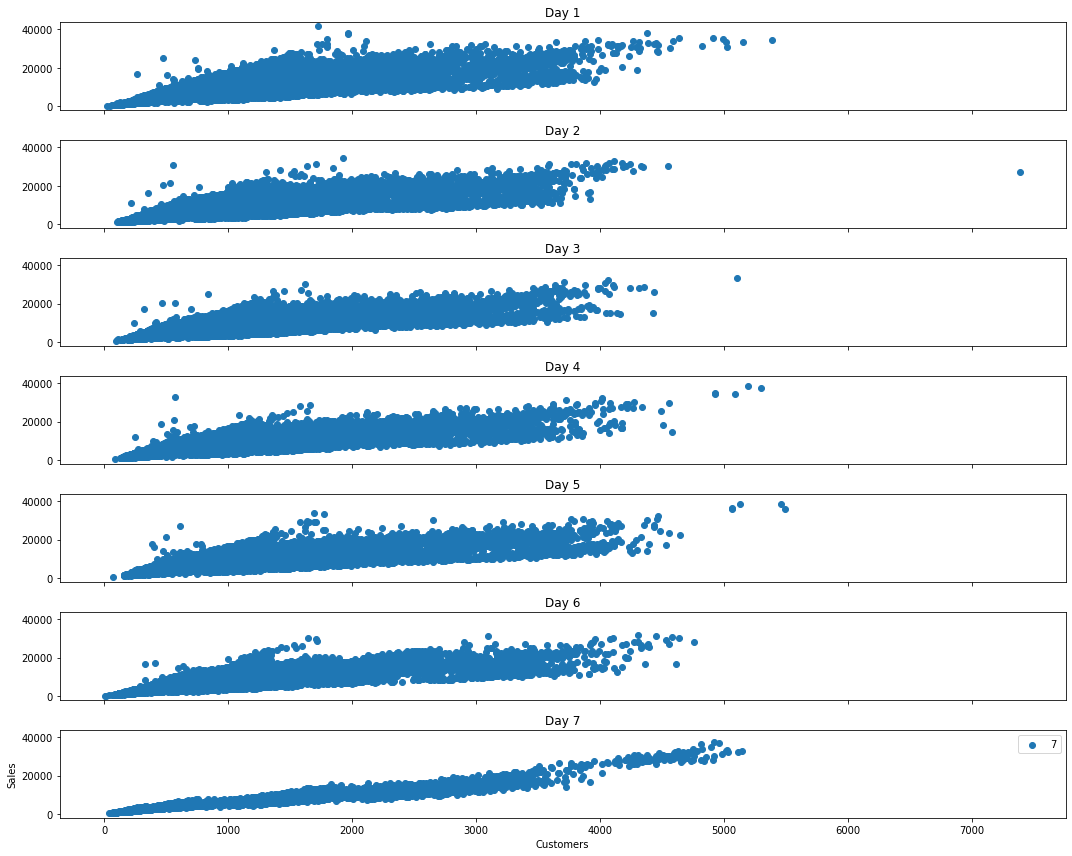

In [15]:
#Does the particular day in the week affect the sales/
plt.rcParams['figure.figsize'] = (15.0, 12.0)

f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    data = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

Data interpretation: The sales were lower on the Seventh Day.

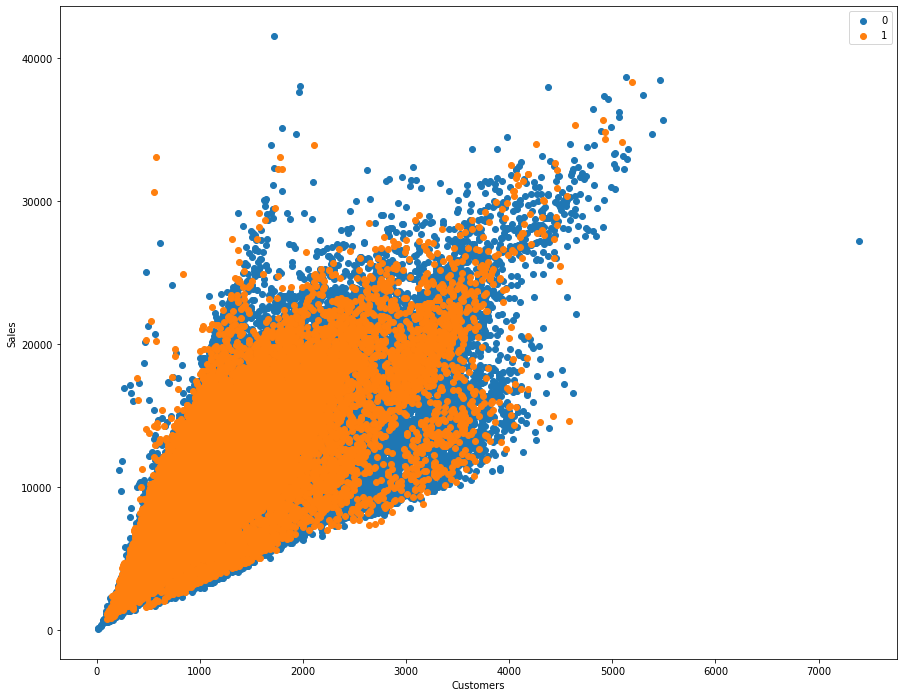

In [16]:
#To find if whether school holidays will affect sales or not

for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

Data interpretation: The occurrence of school holidays are not affecting the sales much.

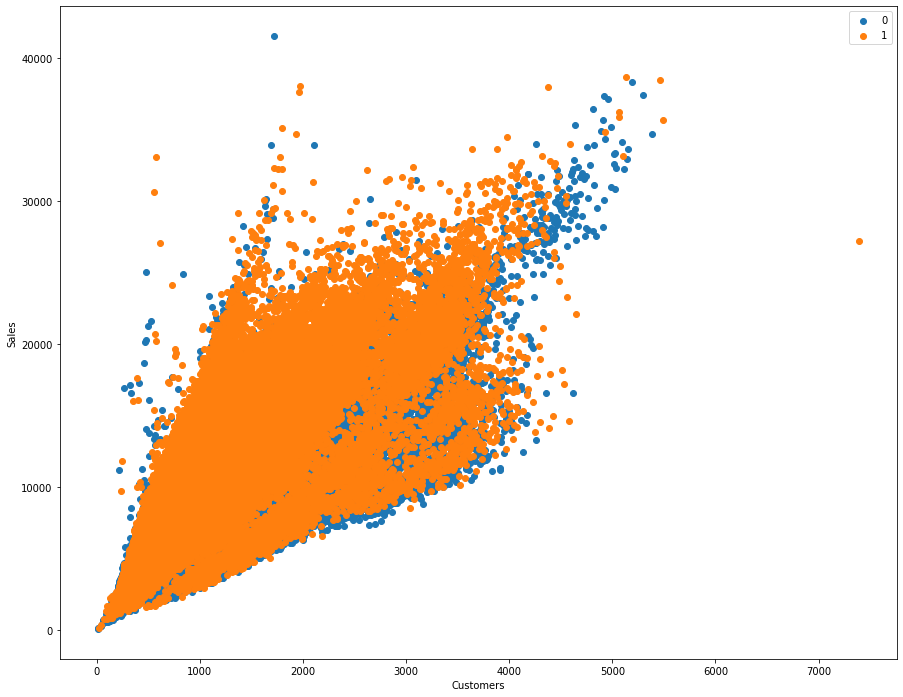

In [17]:
for i in [0, 1]:
    data = train[train['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

Data interpretation: There is minimum impact of the occurrence of promotions on the sales.

In [18]:
#generate the new feature SalesPerCustomer

train['SalesPerCustomer']= train['Sales']/train['Customers']


In [19]:
avg_store=train.groupby('Store')[['Sales','Customers','SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: "Avg" +x, inplace=True)
store=pd.merge(avg_store.reset_index(),store, on="Store")
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4759.096031,564.049936,8.393038,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4953.900510,583.998724,8.408443,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6942.568678,750.077022,9.117599,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9638.401786,1321.752551,7.249827,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4676.274711,537.340180,8.611229,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [20]:
avg_store.head()

,AvgSales,AvgCustomers,AvgSalesPerCustomer
Store,,,
1,4759.096031,564.049936,8.393038
2,4953.900510,583.998724,8.408443
3,6942.568678,750.077022,9.117599
4,9638.401786,1321.752551,7.249827
5,4676.274711,537.340180,8.611229


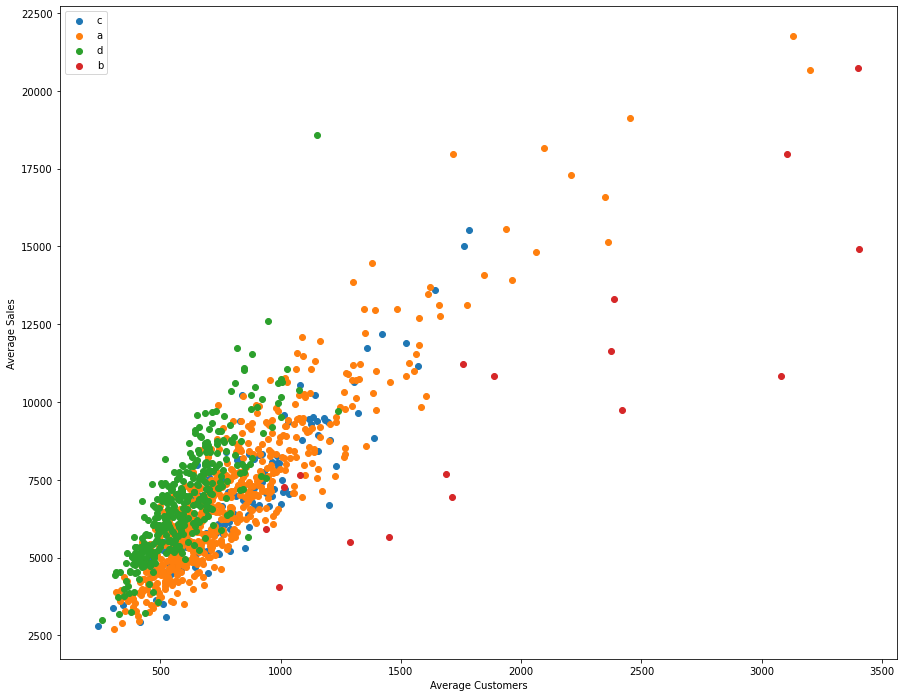

In [21]:
#How the average sales and customer numbers would be affected by the store type
for i in store.StoreType.unique():
    data = store[store['StoreType'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

Data interpretation: Store d in general has the highest average sales compared to the three other stores.

In [22]:
store.Assortment.unique()

array(['a', 'c', 'b'], dtype=object)

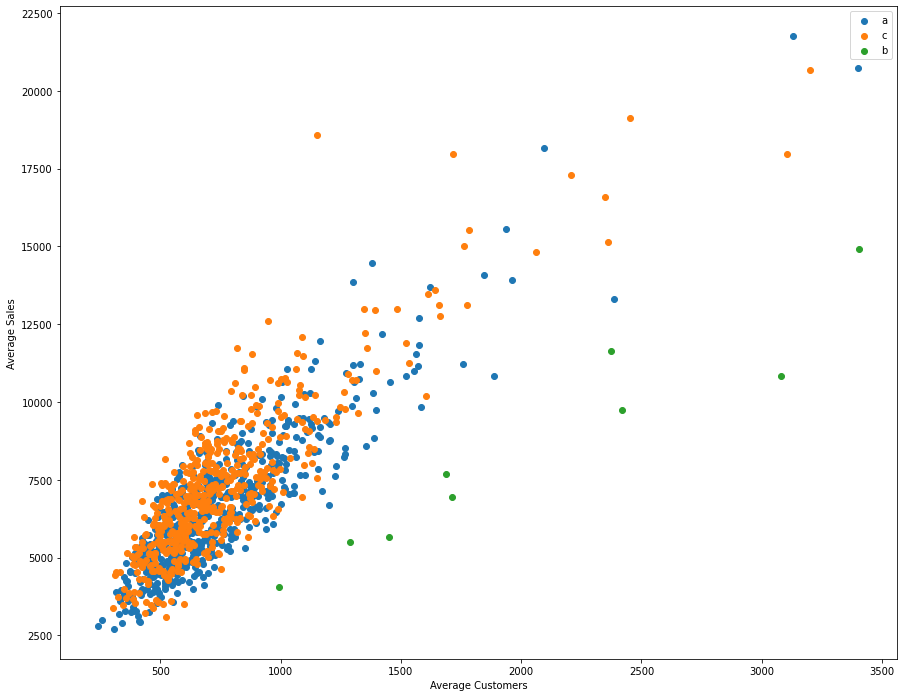

In [23]:
for i in store.Assortment.unique():
    data = store[store['Assortment'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

In [24]:
store.Promo2.unique()

array([0, 1], dtype=int64)

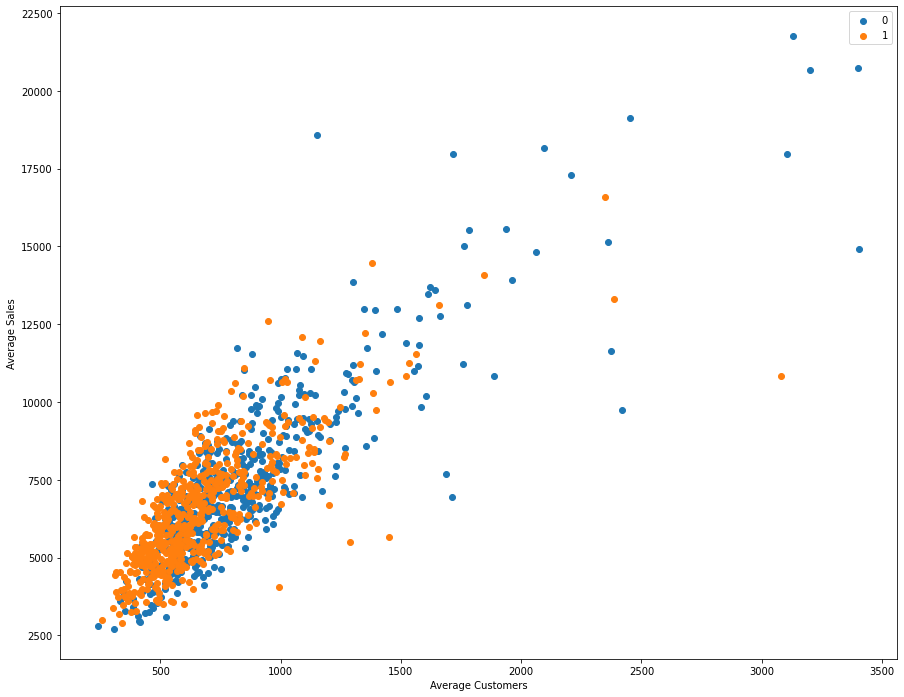

In [25]:
for i in store.Promo2.unique():
    data = store[store['Promo2'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

# Feature Engineering

In [26]:
#check for missing values
store.isnull().sum()

Store                          0
AvgSales                       0
AvgCustomers                   0
AvgSalesPerCustomer            0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

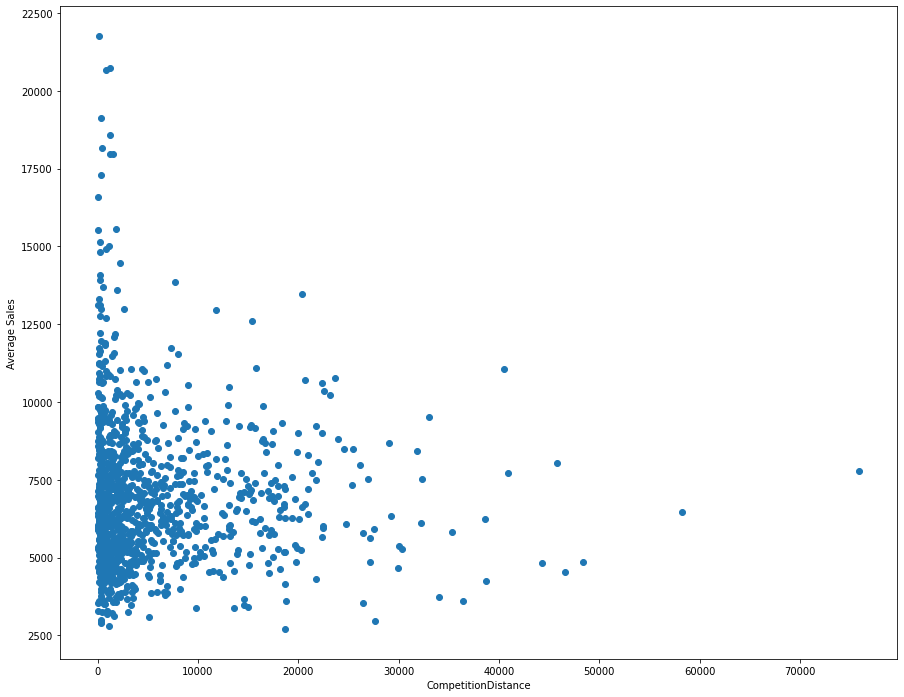

In [27]:
# fill NaN values
store["CompetitionDistance"].fillna(-1)


plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()

In [28]:
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4759.096031,564.049936,8.393038,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4953.900510,583.998724,8.408443,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6942.568678,750.077022,9.117599,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9638.401786,1321.752551,7.249827,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4676.274711,537.340180,8.611229,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [29]:
store['StoreType'] = store['StoreType'].astype('category').cat.codes
store['Assortment'] = store['Assortment'].astype('category').cat.codes
train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4759.096031,564.049936,8.393038,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4953.900510,583.998724,8.408443,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6942.568678,750.077022,9.117599,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9638.401786,1321.752551,7.249827,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4676.274711,537.340180,8.611229,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [30]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883
1,2,5,2015-07-31,6064,625,1,1,1,1,9.702400
2,3,5,2015-07-31,8314,821,1,1,1,1,10.126675
3,4,5,2015-07-31,13995,1498,1,1,1,1,9.342457
4,5,5,2015-07-31,4822,559,1,1,1,1,8.626118


In [35]:
merged = pd.merge(train, store, on='Store', how='left')
merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883,...,8.393038,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,1,1,9.702400,...,8.408443,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,1,1,10.126675,...,9.117599,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,1,1,9.342457,...,7.249827,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,1,1,8.626118,...,8.611229,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [36]:
merged.shape

(844338, 22)

In [37]:
merged.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
SalesPerCustomer                  0
AvgSales                          0
AvgCustomers                      0
AvgSalesPerCustomer               0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

In [38]:
# replacing NaNs with 0
merged.fillna(0, inplace=True)

In [39]:
merged['Date'] = pd.to_datetime(merged['Date'])
merged.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                           int8
SchoolHoliday                         int64
SalesPerCustomer                    float64
AvgSales                            float64
AvgCustomers                        float64
AvgSalesPerCustomer                 float64
StoreType                              int8
Assortment                             int8
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [40]:
merged['Year'] = merged.Date.dt.year
merged['Month'] = merged.Date.dt.month
merged['Day'] = merged.Date.dt.day
merged['Week'] = merged.Date.dt.week
merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883,...,9.0,2008.0,0,0.0,0.0,0,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,1,1,9.702400,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,1,1,10.126675,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,1,1,9.342457,...,9.0,2009.0,0,0.0,0.0,0,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,1,1,8.626118,...,4.0,2015.0,0,0.0,0.0,0,2015,7,31,31


In [41]:
# Number of months that competition has existed for
merged['MonthsCompetitionOpen'] = 12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + (merged['Month'] - merged['CompetitionOpenSinceMonth'])
merged.loc[merged['CompetitionOpenSinceYear'] == 0, 'MonthsCompetitionOpen'] = 0

In [42]:

# Number of weeks that promotion has existed for
merged['WeeksPromoOpen'] = 12 * (merged['Year'] - merged['Promo2SinceYear']) + (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
merged.loc[merged['Promo2SinceYear'] == 0, 'WeeksPromoOpen'] = 0

In [43]:
merged.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                           int8
SchoolHoliday                         int64
SalesPerCustomer                    float64
AvgSales                            float64
AvgCustomers                        float64
AvgSalesPerCustomer                 float64
StoreType                              int8
Assortment                             int8
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Year                            

In [44]:
toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 
        'Promo2SinceYear', 
        'MonthsCompetitionOpen', 
        'WeeksPromoOpen']

merged[toInt] = merged[toInt].astype(int)

In [45]:
med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')

In [46]:
store.head()

,Store,MedSales,MedCustomers,MedSalesPerCustomer,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4647.0,550.0,8.362376,4759.096031,564.049936,8.393038,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4783.0,575.5,8.313092,4953.900510,583.998724,8.408443,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6619.0,744.0,9.123440,6942.568678,750.077022,9.117599,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,9430.5,1301.5,7.215175,9638.401786,1321.752551,7.249827,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4616.0,564.0,8.584677,4676.274711,537.340180,8.611229,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [48]:
merged = pd.merge(med_store.reset_index(), merged, on='Store')
merged.head()

,Store,MedSales,MedCustomers,MedSalesPerCustomer,DayOfWeek,Date,Sales,Customers,Open,Promo,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,4647.0,550.0,8.362376,5,2015-07-31,5263,555,1,1,...,0,0,0,0,2015,7,31,31,82,0
1,1,4647.0,550.0,8.362376,4,2015-07-30,5020,546,1,1,...,0,0,0,0,2015,7,30,31,82,0
2,1,4647.0,550.0,8.362376,3,2015-07-29,4782,523,1,1,...,0,0,0,0,2015,7,29,31,82,0
3,1,4647.0,550.0,8.362376,2,2015-07-28,5011,560,1,1,...,0,0,0,0,2015,7,28,31,82,0
4,1,4647.0,550.0,8.362376,1,2015-07-27,6102,612,1,1,...,0,0,0,0,2015,7,27,31,82,0


In [49]:
merged.columns

Index(['Store', 'MedSales', 'MedCustomers', 'MedSalesPerCustomer', 'DayOfWeek',
       'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'SalesPerCustomer', 'AvgSales', 'AvgCustomers',
       'AvgSalesPerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'Day', 'Week', 'MonthsCompetitionOpen', 'WeeksPromoOpen'],
      dtype='object')

C:\Users\Hwahwa\Anaconda3\envs\PythonCPU\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Hwahwa\Anaconda3\envs\PythonCPU\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Hwahwa\Anaconda3\envs\PythonCPU\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Hwahwa\A

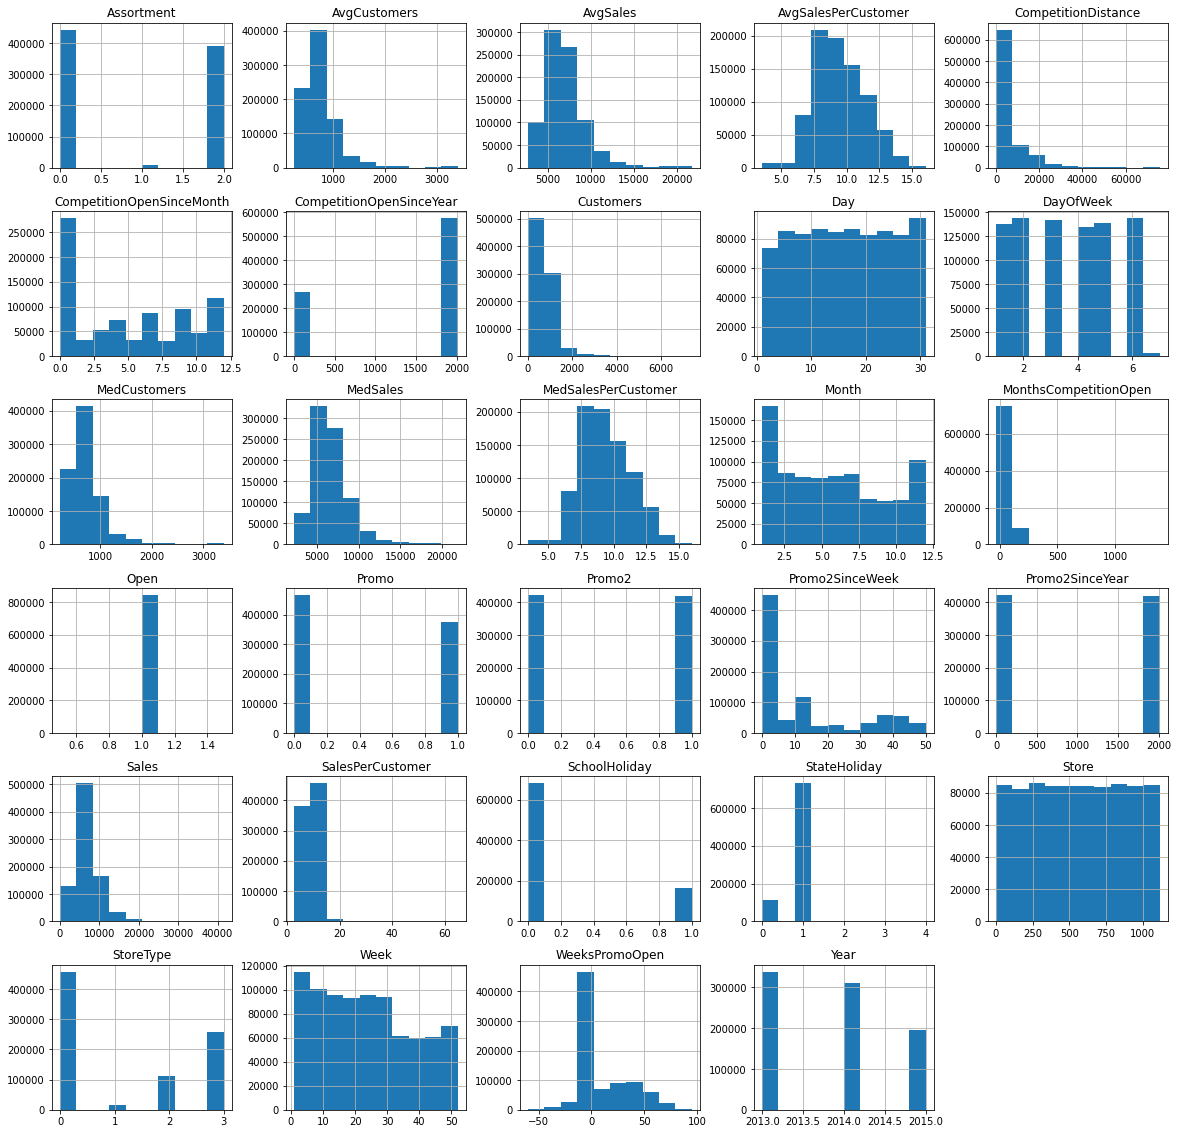

In [50]:
merged.hist(figsize=(20,20))
plt.show()

In [52]:
merged[X].head()

,Store,Customers,CompetitionDistance,Promo,Promo2,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,StateHoliday,...,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,DayOfWeek,Week,Day,Month,Year
0,1,555,1270.0,1,0,9,2008,0,0,1,...,564.049936,8.393038,4647.0,550.0,8.362376,5,31,31,7,2015
1,1,546,1270.0,1,0,9,2008,0,0,1,...,564.049936,8.393038,4647.0,550.0,8.362376,4,31,30,7,2015
2,1,523,1270.0,1,0,9,2008,0,0,1,...,564.049936,8.393038,4647.0,550.0,8.362376,3,31,29,7,2015
3,1,560,1270.0,1,0,9,2008,0,0,1,...,564.049936,8.393038,4647.0,550.0,8.362376,2,31,28,7,2015
4,1,612,1270.0,1,0,9,2008,0,0,1,...,564.049936,8.393038,4647.0,550.0,8.362376,1,31,27,7,2015


# Model Building and Evaluation

In [53]:
from sklearn.model_selection import train_test_split
X = [
    'Store', 
    'Customers',
    'CompetitionDistance', 

    'Promo', 
    'Promo2', 

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

    
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',
    
    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

]
X_data = merged[X]

# We need to perform a log transformation because the sales distribution is skewed.
Y_data = np.log(merged['Sales'])
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.20, random_state=10)

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,mean_squared_error

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)

In [55]:
#using one of the best models for machine learning

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param ={
            'n_estimators': [100,500, 1000,1500],
            'max_depth':[2,4,6,8]
        }

xgboost_tree = xgb.XGBRegressor(
    eta = 0.1,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)

grid = GridSearchCV(estimator=xgboost_tree,param_grid=param,cv=5,  verbose=1, n_jobs=-1,scoring='neg_mean_squared_error')
   
    

    
grid_result = grid.fit(X_train, y_train)
best_params = grid_result.best_params_

print('Best Params :',best_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 136.8min finished


Best Params : {'max_depth': 8, 'n_estimators': 1500}


In [56]:
from math import sqrt
#reverse log the predicted value
pred = grid_result.predict(X_test)
print('Root Mean squared error {}'.format(sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))))

Root Mean squared error 351.130625940233
